In [1]:
# Mounting Google Drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
face_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2/'
pickle_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/aug/'
VM_path = '/content'
VM_face_path = '/content/dataset2'
VM_face_aug_path = '/content/dataset'
train_path = VM_face_aug_path

In [3]:
!cp -r '{face_path}' '{VM_path}'

In [4]:
%mkdir dataset

In [5]:
!rm -r /content/dataset/*

rm: cannot remove '/content/dataset/*': No such file or directory


In [6]:
import os
import pickle
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import keras

In [7]:
def getFace_haar(image):
  max = -1
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  faces = face_dec.detectMultiScale(image, 1.3,5)
  for (x,y,w,h) in faces:
    #print(w,h)
    if w < 20 or h <20:
      continue
    area = h*w
    if max < area:
      max = area
      x1 = x
      y1 = y
      x2 = x+w
      y2 = y+h

    return x1, x2, y1, y2
    

In [8]:
face_dec = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [9]:
#knownface = []
count = 0
k = 1
facelabels = os.listdir(VM_face_path)
for f in facelabels:
  sorc = VM_face_path+'/'+f
  dest = VM_face_aug_path+'/'+f
  os.mkdir(dest)
  img_list = os.listdir(sorc)
  print('Processing ',f, str(k), 'out of ', str(len(facelabels)), 'classes')
  k += 1
  for img in img_list:
    imgPath = sorc+'/'+img
    image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
    #faces = face_dec.detectMultiScale(image)

    cord = getFace_haar(image)
    if cord == None:
      continue
    x1,x2, y1, y2 = cord
    face = image[y1:y2, x1:x2]
    
    savepath = dest+'/'+str(count)+'.png'
    count += 1
    '''
    if count >= 5:
      break
    '''
    cv2.imwrite(savepath, face)
  '''
  if count >= 5:
      break
  '''

Processing  Deepika_Padukone 1 out of  20 classes
Processing  Ileana_D_Cruz 2 out of  20 classes
Processing  Aishwarya_Rai 3 out of  20 classes
Processing  Aamir_Khan 4 out of  20 classes
Processing  Farhan_Akhtar 5 out of  20 classes
Processing  Bhumi_Pednekar 6 out of  20 classes
Processing  Akshay_Kumar 7 out of  20 classes
Processing  Ayushmann_Khurrana 8 out of  20 classes
Processing  Anushka_Sharma 9 out of  20 classes
Processing  Anil_Kapoor 10 out of  20 classes
Processing  Arshad_Warsi 11 out of  20 classes
Processing  Disha_Patani 12 out of  20 classes
Processing  Amitabh_Bachchan 13 out of  20 classes
Processing  Abhay_Deol 14 out of  20 classes
Processing  Hrithik_Roshan 15 out of  20 classes
Processing  Abhishek_Bachchan 16 out of  20 classes
Processing  Ajay_Devgn 17 out of  20 classes
Processing  Alia_Bhatt 18 out of  20 classes
Processing  Emraan_Hashmi 19 out of  20 classes
Processing  Aftab_Shivdasani 20 out of  20 classes


In [10]:

from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = [224,224]
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 20,
                                   brightness_range = [0.5,1.5],
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(VM_face_path,
                                                 target_size = IMAGE_SIZE,
                                                  color_mode='grayscale',
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='training')

testing_set = train_datagen.flow_from_directory(VM_face_path,
                                                 target_size = IMAGE_SIZE,
                                                 color_mode='grayscale',
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='validation')




Found 1972 images belonging to 20 classes.
Found 484 images belonging to 20 classes.


In [11]:
# Training Phase

In [13]:
img_size = 224
shape = (img_size, img_size, 1)
model = Sequential()


model.add(Conv2D(32, (3,3), activation= 'relu', padding='same', input_shape=(img_size, img_size, 1) ))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add( MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation= 'relu' ))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add( MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation= 'relu' ))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add( MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(facelabels), activation='softmax'))

checkpoint = ModelCheckpoint(filepath=pickle_path+'/myOwnCNN_celeb_dataset_checkpoint_weights.hdf5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max',
                             save_freq='epoch')

myopt0 = Adam(lr=0.0001)
myopt1 = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(loss= 'categorical_crossentropy', optimizer=myopt0, metrics=['accuracy'])


In [14]:
'''
train_y = np.asarray(y)
print(X_train.shape)
print(train_y.shape)
'''
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 222, 222, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 107, 107, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 51, 51, 64)       

In [15]:
model_hist= model.fit(training_set, validation_data= testing_set, batch_size = 32, epochs=64, callbacks=[checkpoint])

Epoch 1/64
12/62 [====>.........................] - ETA: 26s - loss: 2.9927 - accuracy: 0.0760

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but o

16/62 [======>.......................] - ETA: 29s - loss: 2.9916 - accuracy: 0.0743

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


27/62 [============>.................] - ETA: 20s - loss: 2.9890 - accuracy: 0.0727

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15191503488 bytes but only got 0. Skipping tag 8126
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


30/62 [=============>................] - ETA: 19s - loss: 2.9889 - accuracy: 0.0721

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


62/62 [==============================] - ETA: 0s - loss: 2.9869 - accuracy: 0.0693

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 9. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7762047328 bytes but only got 0. Skipping tag 39935
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


62/62 [==============================] - 82s 759ms/step - loss: 2.9869 - accuracy: 0.0694 - val_loss: 2.9716 - val_accuracy: 0.0785
Epoch 2/64
62/62 [==============================] - 45s 721ms/step - loss: 2.9729 - accuracy: 0.0668 - val_loss: 2.9481 - val_accuracy: 0.0785
Epoch 3/64
62/62 [==============================] - 44s 711ms/step - loss: 2.9457 - accuracy: 0.0770 - val_loss: 2.9096 - val_accuracy: 0.1384
Epoch 4/64
62/62 [==============================] - 44s 716ms/step - loss: 2.8883 - accuracy: 0.1099 - val_loss: 2.8467 - val_accuracy: 0.1074
Epoch 5/64
62/62 [==============================] - 44s 708ms/step - loss: 2.8288 - accuracy: 0.1185 - val_loss: 2.8098 - val_accuracy: 0.1364
Epoch 6/64
62/62 [==============================] - 44s 701ms/step - loss: 2.7798 - accuracy: 0.1388 - val_loss: 2.7741 - val_accuracy: 0.1157
Epoch 7/64
62/62 [==============================] - 44s 702ms/step - loss: 2.7522 - accuracy: 0.1516 - val_loss: 2.7522 - val_accuracy: 0.1364
Epoch 8/64

In [16]:
model_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/aug/myOwnCNN_celeb_dataset.h5'
model.save(model_path)

In [17]:
m = []
for i in range(64):
  m.append(i)

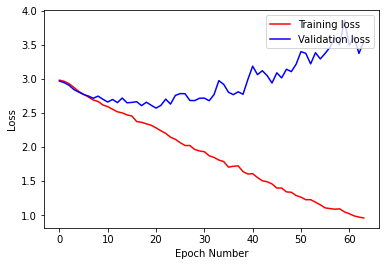

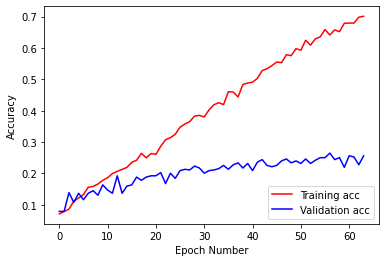

In [18]:

loss_trace = model_hist.history['loss']
val_loss_trace = model_hist.history['val_loss']
plt.plot(m,loss_trace, c='r')
plt.plot(m,val_loss_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()


accuracy_trace = model_hist.history['accuracy']
val_accuracy_trace = model_hist.history['val_accuracy']
plt.plot(m,accuracy_trace, c='r')
plt.plot(m,val_accuracy_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'], loc='lower right')
plt.show()
